# Image Classification Using Transfer Learning 

image classification of alpacas and not alpacas based on pre-training CNN. 

## 1. Import the required packets


In [187]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

## 2. Load and split the dataset 

the dataset should be divided into training and test sets (train, validation). The dataset for this research consists of two files: "not alpacas," which includes photographs of other animals, and "alpacas," which contains images of alpacas (i.e., not alpacas). The Kerase method **(image dataset from directory)** allows the dataset to be quickly loaded and stored into training and testing sets.


**validation_split=0.2** split the dataset to be 80% for training and 20% for testing 

In [188]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
test_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Displaying some images from the dataset to see how the animals are doing these days

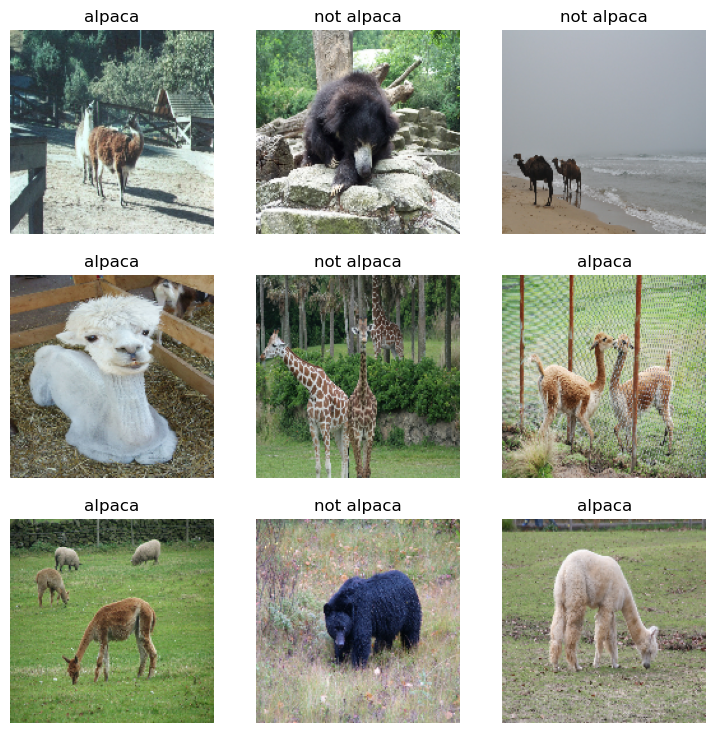

In [189]:
class_names = train_dataset.class_names

# take(1) take one batch from training set

plt.figure(figsize=(9, 9))

for images, labels in train_dataset.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Prefetching

TensorFlow performs this process, making use of all the memory space at its disposal by retrieving data from the disk and processing additional data if it can and if there is space in the memory. to instruct the system to skip awaiting additional data once it has finished processing. This takes less time and can increase system performance.

In [190]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### Agumention
The agumention is a technique used to expand the sample size when there are insufficient samples in the dataset. This may assist with the overfitting issue.

Implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [191]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

Take a look at how an image from the training set has been augmented with simple transformations:
From one cute animal, to 9 variations of that cute animal, in three lines of code. Now your model has a lot more to learn from.

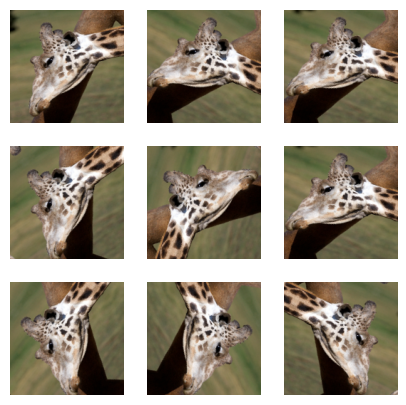

In [192]:
# Disapear the ERROR
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# 3.  Using MobileNetV2 for Transfer Learning

MobileNetV2 is a convolutional neural network designed for classification. It is trained using ImageNet, which is a very large dataset containing 14 million images related to a wide range of categories such as people, animals, objects, etc. Because it can detect the animal type, it can be used to recognize alpacas.


In [193]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [194]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

# 4. Alpaca Model 

Make the input proper for mobilenet v2 by this code.

In [195]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [196]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
    prediction_layer = tfl.Dense(1)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = prediction_layer(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [197]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [198]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [199]:
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=test_dataset, epochs=initial_epochs)

Epoch 1/10
9/9 [==============================] - 11s 679ms/step - loss: 0.8219 - accuracy: 0.4618 - val_loss: 0.5564 - val_accuracy: 0.6769
Epoch 2/10
9/9 [==============================] - 6s 599ms/step - loss: 0.6700 - accuracy: 0.5992 - val_loss: 0.4389 - val_accuracy: 0.7231
Epoch 3/10
9/9 [==============================] - 6s 581ms/step - loss: 0.5006 - accuracy: 0.7137 - val_loss: 0.3804 - val_accuracy: 0.7077
Epoch 4/10
9/9 [==============================] - 6s 624ms/step - loss: 0.4651 - accuracy: 0.7634 - val_loss: 0.3158 - val_accuracy: 0.8000
Epoch 5/10
9/9 [==============================] - 7s 665ms/step - loss: 0.4001 - accuracy: 0.7901 - val_loss: 0.3030 - val_accuracy: 0.7692
Epoch 6/10
9/9 [==============================] - 6s 621ms/step - loss: 0.4319 - accuracy: 0.7634 - val_loss: 0.2497 - val_accuracy: 0.8615
Epoch 7/10
9/9 [==============================] - 6s 624ms/step - loss: 0.3835 - accuracy: 0.8092 - val_loss: 0.2317 - val_accuracy: 0.8769
Epoch 8/10
9/9 [===

Test images 

1/1 [==============================] - 0s 81ms/step
Not an Alpaca
Not an Alpaca


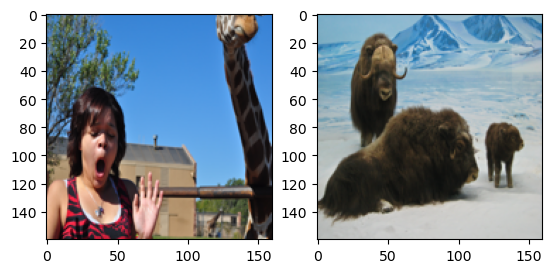

In [239]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

IMG_SIZE = (160, 160) # set the image size

# Load the images
img1 = Image.open('dataset/not alpaca/0ff3adf2084ca670.jpg').resize(IMG_SIZE)
img2 = Image.open('dataset/not alpaca/1baa67b7a05a87c6.jpg').resize(IMG_SIZE)

# Convert the images to numpy arrays
x1 = np.array(img1)
x2 = np.array(img2)

# Make predictions
preds1 = model2.predict(np.array([x1]))
preds2 = model2.predict(np.array([x2]))

# Print the results
if preds1 > 0:
    print("Not an Alpaca")
else:
    print('Alpaca')
    
if preds2 > 0:
    print("Not an Alpaca")
else:
    print('Alpaca')

# Display the images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

In [240]:
history.history['accuracy']

[0.46183204650878906,
 0.5992366671562195,
 0.7137404680252075,
 0.7633587718009949,
 0.7900763154029846,
 0.7633587718009949,
 0.8091602921485901,
 0.805343508720398,
 0.8435114622116089,
 0.8511450290679932]

In [203]:
history.history['val_accuracy']

[0.6769230961799622,
 0.7230769395828247,
 0.7076923251152039,
 0.800000011920929,
 0.7692307829856873,
 0.8615384697914124,
 0.8769230842590332,
 0.8615384697914124,
 0.8769230842590332,
 0.9076923131942749]

Above the system, it was designed to just remove the last layer and change from softmax to binary, then train the mobilev2 using the dataset. Now, let's train the system using the last few layers.

 ### fine-tuning

In [204]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [205]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 10/15
9/9 [==============================] - 16s 1s/step - loss: 0.4658 - accuracy: 0.8053 - val_loss: 0.1893 - val_accuracy: 0.9385
Epoch 11/15
9/9 [==============================] - 9s 850ms/step - loss: 0.2700 - accuracy: 0.9084 - val_loss: 0.1407 - val_accuracy: 0.9385
Epoch 12/15
9/9 [==============================] - 9s 896ms/step - loss: 0.1801 - accuracy: 0.9122 - val_loss: 0.1353 - val_accuracy: 0.9231
Epoch 13/15
9/9 [==============================] - 8s 846ms/step - loss: 0.1962 - accuracy: 0.9198 - val_loss: 0.0844 - val_accuracy: 0.9846
Epoch 14/15
9/9 [==============================] - 8s 813ms/step - loss: 0.1943 - accuracy: 0.9160 - val_loss: 0.0759 - val_accuracy: 0.9846
Epoch 15/15
9/9 [==============================] - 8s 809ms/step - loss: 0.1545 - accuracy: 0.9618 - val_loss: 0.0705 - val_accuracy: 1.0000


1/1 [==============================] - 0s 34ms/step
Not an Alpaca
Alpaca


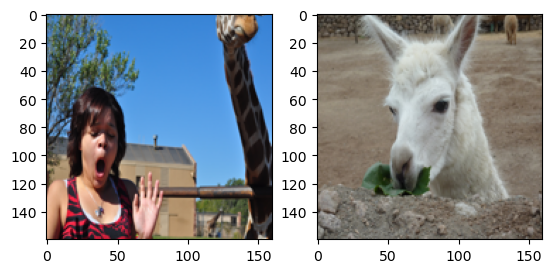

In [225]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

IMG_SIZE = (160, 160) # set the image size

# Load the images
img1 = Image.open('dataset/not alpaca/0ff3adf2084ca670.jpg').resize(IMG_SIZE)
img2 = Image.open('dataset/alpaca/0cb5cae66bb9c4cd.jpg').resize(IMG_SIZE)

# Convert the images to numpy arrays
x1 = np.array(img1)
x2 = np.array(img2)

# Make predictions
preds1 = model2.predict(np.array([x1]))
preds2 = model2.predict(np.array([x2]))

# Print the results
if preds1 > 0:
    print("Not an Alpaca")
else:
    print('Alpaca')
    
if preds2 > 0:
    print("Not an Alpaca")
else:
    print('Alpaca')

# Display the images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()
